In [1]:
!nvidia-smi

Tue Jul 21 10:37:33 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 451.48       Driver Version: 451.48       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 2070   WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   44C    P8    13W /  N/A |    540MiB /  8192MiB |      5%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

In [2]:
# !pip install pytorch_transformers

# # loading the packages

In [2]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F


import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split


from pytorch_transformers import XLNetModel, XLNetTokenizer, XLNetForSequenceClassification
from pytorch_transformers import AdamW

from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

device

device(type='cuda', index=0)

### Loading the Data

In [4]:

raw_data = pd.read_csv("app_scraped_data.csv")



In [5]:
print (raw_data.shape)
raw_data.head(2)

(16054, 12)


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOEtpLcODD_NZOBqR1N7DBbaLdw3Gyz3v3xZAp1...,Mad Scientist,https://lh3.googleusercontent.com/-kIZF4kMt6yY...,"Unable to register with an email. Clicking""con...",1,76,5.2.0.9,2020-07-10 23:29:22,We are unaware of any issues with signing in t...,2020-07-12 13:32:19,most_relevant,com.anydo
1,gp:AOqpTOGG5EdQ69VnyUoJ2bJ4jB_hWqNeLh9nZ-ULOVz...,Sergey P,https://lh3.googleusercontent.com/a-/AOh14GgVZ...,Any.Forget... Had an instance of daily repeati...,1,12,5.2.0.9,2020-07-08 15:07:48,Our team will be happy to look into this issue...,2020-07-09 13:49:41,most_relevant,com.anydo


In [6]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16054 entries, 0 to 16053
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              16054 non-null  object
 1   userName              16054 non-null  object
 2   userImage             16054 non-null  object
 3   content               16054 non-null  object
 4   score                 16054 non-null  int64 
 5   thumbsUpCount         16054 non-null  int64 
 6   reviewCreatedVersion  13779 non-null  object
 7   at                    16054 non-null  object
 8   replyContent          7896 non-null   object
 9   repliedAt             7896 non-null   object
 10  sortOrder             16054 non-null  object
 11  appId                 16054 non-null  object
dtypes: int64(2), object(10)
memory usage: 1.5+ MB


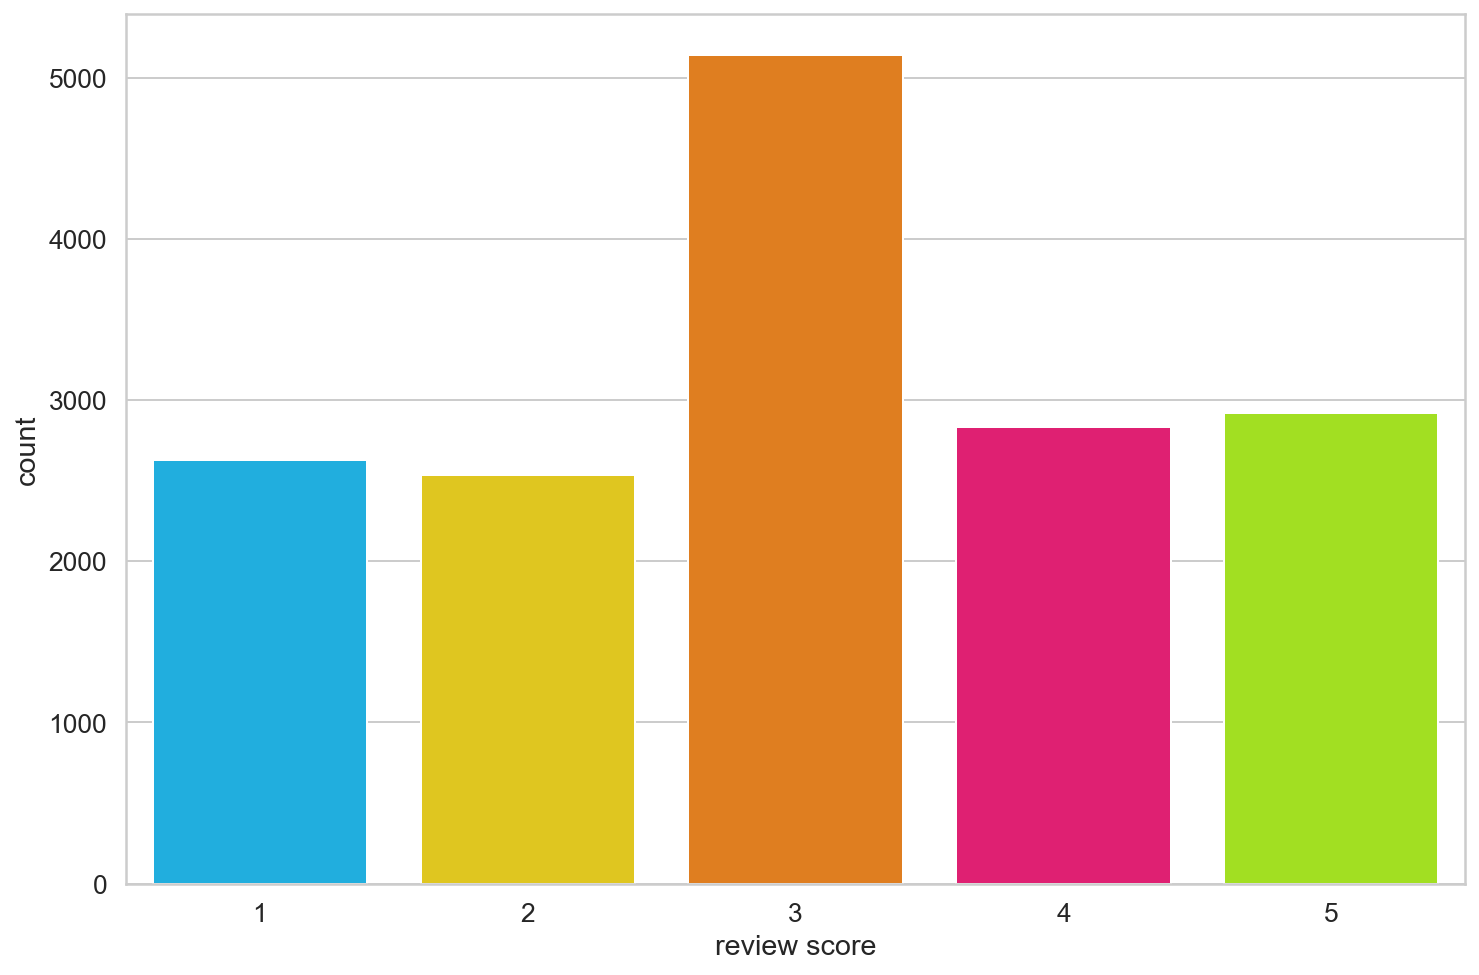

In [7]:
sns.countplot(raw_data.score)
plt.xlabel('review score');

### Creating positive, neutral and negative based on the scores given by the users

In [9]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else: 
    return 2

raw_data['sentiment'] = raw_data.score.apply(to_sentiment)

In [10]:
raw_data.head(2)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId,sentiment
0,gp:AOqpTOEtpLcODD_NZOBqR1N7DBbaLdw3Gyz3v3xZAp1...,Mad Scientist,https://lh3.googleusercontent.com/-kIZF4kMt6yY...,"Unable to register with an email. Clicking""con...",1,76,5.2.0.9,2020-07-10 23:29:22,We are unaware of any issues with signing in t...,2020-07-12 13:32:19,most_relevant,com.anydo,0
1,gp:AOqpTOGG5EdQ69VnyUoJ2bJ4jB_hWqNeLh9nZ-ULOVz...,Sergey P,https://lh3.googleusercontent.com/a-/AOh14GgVZ...,Any.Forget... Had an instance of daily repeati...,1,12,5.2.0.9,2020-07-08 15:07:48,Our team will be happy to look into this issue...,2020-07-09 13:49:41,most_relevant,com.anydo,0


In [11]:
raw_data.sentiment.value_counts()

2    5750
0    5164
1    5140
Name: sentiment, dtype: int64

In [12]:
class_names = ['negative', 'neutral', 'positive']

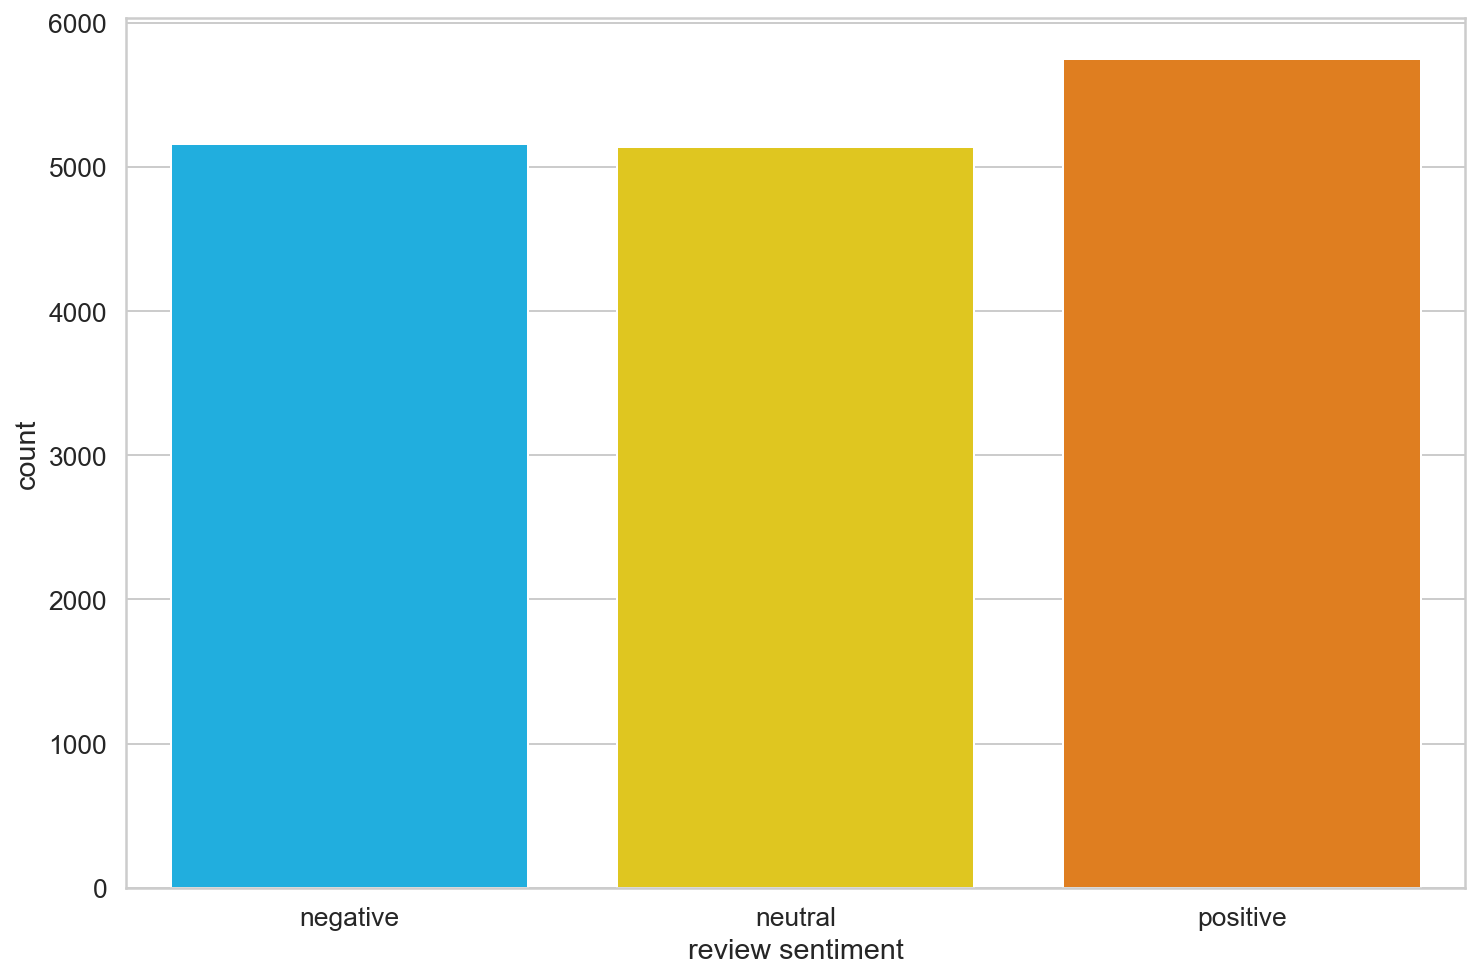

In [13]:
ax = sns.countplot(raw_data.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

In [15]:
sentences = [sentence for sentence in raw_data.content]
labels = raw_data.sentiment

# Preprocessing the text

In [16]:
# Lower cases 
sentences = [sentence.lower() for sentence in sentences]

import re
sentences= [re.sub(r'\d+', '', sentence) for sentence in sentences]

# Remove punctuation

import string
import re

def remove_punctuation(text): 
#     translator = str.maketrans(" ", " ", string.punctuation) 
#     return text.translate(translator) 
#     translator = re.compile('[%s]' % re.escape(string.punctuation))
#     translator.sub(' ', text)
    txt = text.translate(str.maketrans(string.punctuation, ' ' * len(string.punctuation))).replace(' '*4, ' ').replace(' '*3, ' ').replace(' '*2, ' ').strip()
#     txt = txt + " [SEP] [CLS]" 
    return(txt)

# remove white spaces
sentences = [remove_punctuation(sentence) for sentence in sentences]

def remove_whitespace(text): 
    return  " ".join(text.split()) 
  
sentences = [remove_whitespace(sentence) for sentence in sentences]

# remove stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
def stop_words(sentence):    
    stop_words = set(stopwords.words('english'))
    token_words=word_tokenize(sentence)
    token_words
    stem_sentence=[]
    for word in token_words:
        if word not in stop_words:
            
            stem_sentence.append(word)
            stem_sentence.append(" ")
    return "".join(stem_sentence)

sentences= [stop_words(sentence) for sentence in sentences]

# Lemmatizer
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
    
def lemmatizeSentence(sentence):    
    token_words=word_tokenize(sentence)
    token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

sentences= [lemmatizeSentence(sentence) for sentence in sentences]

sentences = [sentence + " [SEP] [CLS]" for sentence in sentences]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [20]:
# # https://www.datacamp.com/community/tutorials/stemming-lemmatization-python

# from nltk.stem import PorterStemmer
# from nltk.stem import LancasterStemmer
# from nltk.tokenize import word_tokenize
# porter = PorterStemmer()
# lancaster=LancasterStemmer()

# from nltk.tokenize import sent_tokenize, word_tokenize
# def stemSentence(sentence):
#     token_words=word_tokenize(sentence)
#     token_words
#     stem_sentence=[]
#     for word in token_words:
#         stem_sentence.append(porter.stem(word))
#         stem_sentence.append(" ")
#     return "".join(stem_sentence)

# sentences_5 = [stemSentence(sentence) for sentence in sentences_4]
# print(sentences_4[0])
# print()
# print(sentences_5[0])


In [18]:
raw_data.content[0]

'Unable to register with an email. Clicking"continue with email" will just take you to a login page. Complete waste of time. I searched them first three pages of Google for a solution and found nothing. Found no solution on their help section. I don\'t want to register with Facebook or Google. If you include a feature, make sure it actually works.'

In [17]:
sentences[0]

'unable register email click continue email take login page complete waste time search first three page google solution find nothing find solution help section want register facebook google include feature make sure actually work  [SEP] [CLS]'

## Model Building using pytorch

#### loading pretrained XLNetTokenizer classifers

In [22]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Tokenize the first sentence:
['▁unable', '▁register', '▁email', '▁click', '▁continue', '▁email', '▁take', '▁login', '▁page', '▁complete', '▁waste', '▁time', '▁search', '▁first', '▁three', '▁page', '▁', 'google', '▁solution', '▁find', '▁nothing', '▁find', '▁solution', '▁help', '▁section', '▁want', '▁register', '▁face', 'book', '▁', 'google', '▁include', '▁feature', '▁make', '▁sure', '▁actually', '▁work', '▁[', 's', 'ep', ']', '▁[', 'cl', 's', ']']


In [24]:
token_lens = []

for txt in sentences:
  tokens = tokenizer.encode(txt)
  token_lens.append(len(tokens))

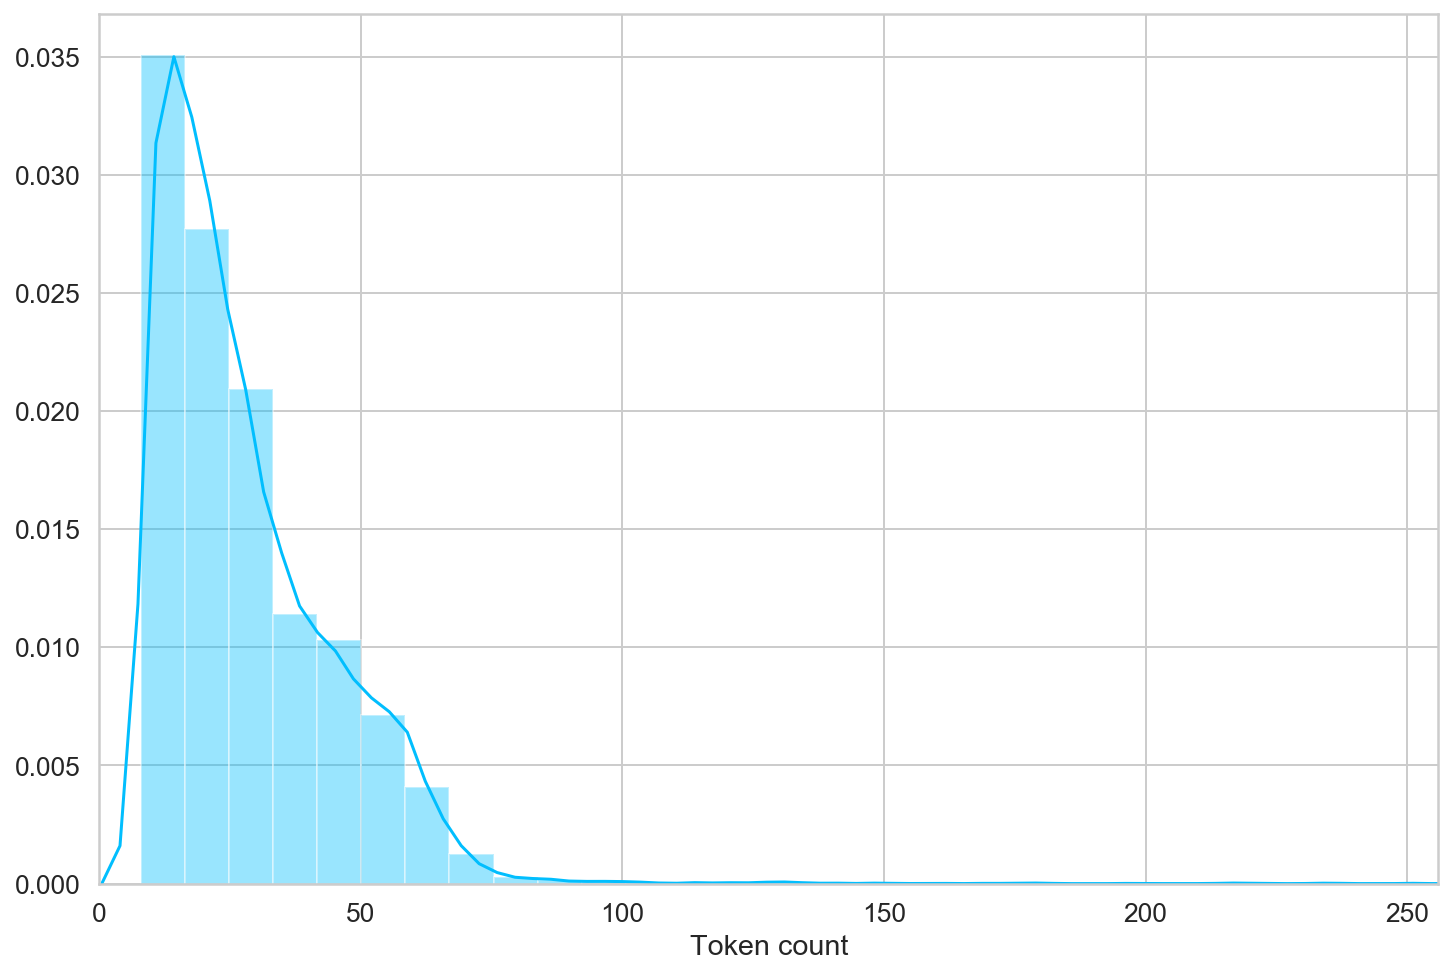

In [25]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [26]:
tokenizer.tokenize("Rahul")

['▁', 'rah', 'ul']

In [27]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# n_gpu = torch.cuda.device_count()
# torch.cuda.get_device_name(0)

In [28]:
MAX_LEN = 100

### left padding each reviews with fixed length

In [29]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [30]:
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")


In [31]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [32]:
labels

0        0
1        0
2        0
3        0
4        0
        ..
16049    2
16050    2
16051    2
16052    2
16053    2
Name: sentiment, Length: 16054, dtype: int64

In [33]:
input_ids

array([[2806, 4081, 1706, ...,    0,    0,    0],
       [3795, 3431, 1362, ...,    0,    0,    0],
       [ 154, 4968, 6390, ...,    0,    0,    0],
       ...,
       [ 312,  625, 4145, ...,    0,    0,    0],
       [ 252,  493, 5523, ...,    0,    0,    0],
       [2712, 4145,   23, ...,    0,    0,    0]])

In [34]:
# train_labels

In [35]:
#Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=56, test_size=0.2)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=56, test_size=0.2)

In [36]:
# Convert all of our data into torch tensors, the required datatype for our model
# torch.tensor(train).to(torch.int64)
train_inputs = torch.tensor(train_inputs).to(torch.int64)
validation_inputs = torch.tensor(validation_inputs).to(torch.int64)
train_labels = torch.tensor(train_labels.to_numpy()).to(torch.int64)
validation_labels = torch.tensor(validation_labels.to_numpy()).to(torch.int64)
train_masks = torch.tensor(train_masks).to(torch.int64).to(torch.int64)
validation_masks = torch.tensor(validation_masks).to(torch.int64)

In [37]:
# Select a batch size for training. For fine-tuning with XLNet, the authors recommend a batch size of 32, 48, or 128. We will use 32 here to avoid memory issues.
batch_size = 16

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [38]:
import torch
from pytorch_transformers import XLNetConfig
from pytorch_transformers import XLNetTokenizer
from pytorch_transformers import XLNetForSequenceClassification
from transformers import XLNetConfig, XLNetModel

In [39]:
import torch

from transformers import XLNetForSequenceClassification

model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=3)

model.cuda()

param_optimizer = list(model.named_parameters())
no_decay = ['bias','gamma','beta']
optimizer_grouped_parameters = [
    {'params':[p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
      'weight_decay_rate':0.01},
    {'params':[p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
      'weight_decay_rate':0.0}
]

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [40]:
# # Load XLNEtForSequenceClassification, the pretrained XLNet model with a single linear classification layer on top. 

# model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=2)
# # model.cuda()

In [41]:
# param_optimizer = list(model.named_parameters())
# no_decay = ['bias', 'gamma', 'beta']
# optimizer_grouped_parameters = [
#     {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
#      'weight_decay_rate': 0.01},
#     {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
#      'weight_decay_rate': 0.0}
# ]

In [42]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(optimizer_grouped_parameters,
                     lr=2e-5)

In [43]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [44]:
import time
start = time.time()

# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 25

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs[0]
    logits = outputs[1]
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      logits = output[0]
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))


##################
  # train

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in train_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      logits = output[0]
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("train  Accuracy: {}".format(eval_accuracy/nb_eval_steps))

end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

Epoch:   0%|                                                                                    | 0/25 [00:00<?, ?it/s]..\torch\csrc\utils\python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


Train loss: 0.9082349054097832
Validation Accuracy: 0.6227103120759837


Epoch:   4%|██▉                                                                      | 1/25 [11:19<4:31:59, 679.98s/it]

train  Accuracy: 0.646687139137326
Train loss: 0.7356081676215935
Validation Accuracy: 0.6695217096336499


Epoch:   8%|█████▊                                                                   | 2/25 [22:47<4:21:32, 682.27s/it]

train  Accuracy: 0.7656939884523944
Train loss: 0.6150899294712772
Validation Accuracy: 0.7186510628674807


Epoch:  12%|████████▊                                                                | 3/25 [34:18<4:11:06, 684.83s/it]

train  Accuracy: 0.8415459073927318
Train loss: 0.480337316701525
Validation Accuracy: 0.754692446856626


Epoch:  16%|███████████▋                                                             | 4/25 [45:52<4:00:36, 687.47s/it]

train  Accuracy: 0.9051992528019925
Train loss: 0.35958615221908946
Validation Accuracy: 0.780529172320217


Epoch:  20%|██████████████▌                                                          | 5/25 [57:27<3:49:54, 689.73s/it]

train  Accuracy: 0.9443917695007359
Train loss: 0.26545105555824294
Validation Accuracy: 0.791214382632293


Epoch:  24%|█████████████████                                                      | 6/25 [1:09:08<3:39:30, 693.18s/it]

train  Accuracy: 0.944979055813427
Train loss: 0.2144387492847398
Validation Accuracy: 0.8025780189959294


Epoch:  28%|███████████████████▉                                                   | 7/25 [1:20:57<3:29:22, 697.92s/it]

train  Accuracy: 0.9582036114570361
Train loss: 0.1803854670964766
Validation Accuracy: 0.8019561284486657


Epoch:  32%|██████████████████████▋                                                | 8/25 [1:33:09<3:20:37, 708.09s/it]

train  Accuracy: 0.9663407109702252
Train loss: 0.1581662754211598
Validation Accuracy: 0.8115954319312528


Epoch:  36%|█████████████████████████▌                                             | 9/25 [1:46:05<3:14:15, 728.49s/it]

train  Accuracy: 0.9722135740971357
Train loss: 0.13633798780720008
Validation Accuracy: 0.8223371777476255


Epoch:  40%|████████████████████████████                                          | 10/25 [1:58:51<3:04:57, 739.82s/it]

train  Accuracy: 0.9775133023887694
Train loss: 0.12246298724565084
Validation Accuracy: 0.8153267752148349


Epoch:  44%|██████████████████████████████▊                                       | 11/25 [2:11:58<2:55:57, 754.10s/it]

train  Accuracy: 0.973458904109589
Train loss: 0.1122595925640273
Validation Accuracy: 0.8189167797376752


Epoch:  48%|█████████████████████████████████▌                                    | 12/25 [2:24:45<2:44:13, 757.97s/it]

train  Accuracy: 0.9713574097135741
Train loss: 0.10585054690261855
Validation Accuracy: 0.8119063772048847


Epoch:  52%|████████████████████████████████████▍                                 | 13/25 [2:37:34<2:32:13, 761.16s/it]

train  Accuracy: 0.9763387297633873
Train loss: 0.1083330736770428
Validation Accuracy: 0.8300825418362732


Epoch:  56%|███████████████████████████████████████▏                              | 14/25 [2:50:01<2:18:47, 757.03s/it]

train  Accuracy: 0.977895392278954
Train loss: 0.09678811438910542
Validation Accuracy: 0.8218566259611035


Epoch:  60%|██████████████████████████████████████████                            | 15/25 [3:02:44<2:06:26, 758.67s/it]

train  Accuracy: 0.9794520547945206
Train loss: 0.09101158408227737
Validation Accuracy: 0.80958842152872


Epoch:  64%|████████████████████████████████████████████▊                         | 16/25 [3:16:02<1:55:34, 770.46s/it]

train  Accuracy: 0.9805841729876599
Train loss: 0.08790060088669378
Validation Accuracy: 0.8179556761646314


Epoch:  68%|███████████████████████████████████████████████▌                      | 17/25 [3:29:25<1:44:01, 780.19s/it]

train  Accuracy: 0.9801525529265255
Train loss: 0.0847514805663493
Validation Accuracy: 0.8210651289009497


Epoch:  72%|██████████████████████████████████████████████████▍                   | 18/25 [3:41:57<1:30:03, 771.93s/it]

train  Accuracy: 0.9809733386165516
Train loss: 0.08785851313680373
Validation Accuracy: 0.8251074174581637


Epoch:  76%|█████████████████████████████████████████████████████▏                | 19/25 [3:54:20<1:16:19, 763.23s/it]

train  Accuracy: 0.9808530510585305
Train loss: 0.0772259219794315
Validation Accuracy: 0.8126696065128901


Epoch:  80%|████████████████████████████████████████████████████████              | 20/25 [4:06:46<1:03:09, 757.96s/it]

train  Accuracy: 0.9782845579078456
Train loss: 0.07712618105234126
Validation Accuracy: 0.8265208050655811


Epoch:  84%|████████████████████████████████████████████████████████████▍           | 21/25 [4:19:16<50:22, 755.65s/it]

train  Accuracy: 0.9814757160647571
Train loss: 0.08058597014319259
Validation Accuracy: 0.8173620533695161


Epoch:  88%|███████████████████████████████████████████████████████████████▎        | 22/25 [4:31:54<37:48, 756.32s/it]

train  Accuracy: 0.9817092154420921
Train loss: 0.07268611669489954
Validation Accuracy: 0.826831750339213


Epoch:  92%|██████████████████████████████████████████████████████████████████▏     | 23/25 [4:44:24<25:08, 754.44s/it]

train  Accuracy: 0.9821832899354693
Train loss: 0.07544802440936964
Validation Accuracy: 0.8198496155585707


Epoch:  96%|█████████████████████████████████████████████████████████████████████   | 24/25 [4:57:00<12:34, 754.75s/it]

train  Accuracy: 0.9822540473225405
Train loss: 0.07821469996147702
Validation Accuracy: 0.825135685210312


Epoch: 100%|████████████████████████████████████████████████████████████████████████| 25/25 [5:09:37<00:00, 743.09s/it]

train  Accuracy: 0.9817092154420921
05:09:37.35


###### 

In [45]:
torch.save(model.state_dict(), 'model_with_preprocessing.ckpt')


In [46]:
# model = TheModelClass(*args, **kwargs)
# model.load_state_dict(torch.load(PATH))
# model.eval()

In [47]:
# torch.save(model.state_dict(), directory_path+'/model_without_language_model.ckpt')
# Test the model

with torch.no_grad():
    correct = 0
    total = 0
    actual_labels = []
#     pred_labels = []
    for i, batch in enumerate(validation_dataloader):
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      # Forward pass
      outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

      # print (outputs)
      prediction = torch.argmax(outputs[0],dim=1)
      prediction_prob = torch.softmax(outputs[0],dim=1)
      actual_labels.append([b_labels, prediction,prediction_prob])
      total += b_labels.size(0)
      correct+=(prediction==b_labels).sum().item()

In [48]:
actual_list = []
pred = []
pred_prob = []
for i in range(len(actual_labels)):
    actual_list.extend(actual_labels[i][0].cpu().numpy().tolist())
    pred.extend(actual_labels[i][1].cpu().numpy().tolist())
    pred_prob.extend(actual_labels[i][2].cpu().numpy().tolist())
    

In [49]:
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(actual_list, pred)
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)
print (cm)
print ("precision = ", precision)
print ("recall = ", recall)

[[857 105  41]
 [117 808 109]
 [ 70 119 985]]
precision =  [0.82088123 0.78294574 0.86784141]
recall =  [0.85443669 0.78143133 0.83901193]


In [50]:
from sklearn.metrics import accuracy_score


In [51]:
accuracy_score(actual_list, pred)


0.825288072251635

In [52]:
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(actual_list, pred)
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)

print ("product_type_precision = ", precision)
print ("product_type_recall = ", recall)

product_type_precision =  [0.82088123 0.78294574 0.86784141]
product_type_recall =  [0.85443669 0.78143133 0.83901193]


In [53]:
from sklearn.metrics import classification_report

print(classification_report(actual_list, pred))

              precision    recall  f1-score   support

           0       0.82      0.85      0.84      1003
           1       0.78      0.78      0.78      1034
           2       0.87      0.84      0.85      1174

    accuracy                           0.83      3211
   macro avg       0.82      0.82      0.82      3211
weighted avg       0.83      0.83      0.83      3211



In [54]:
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

In [55]:
y = label_binarize(actual_list, classes=[0, 1, 2])

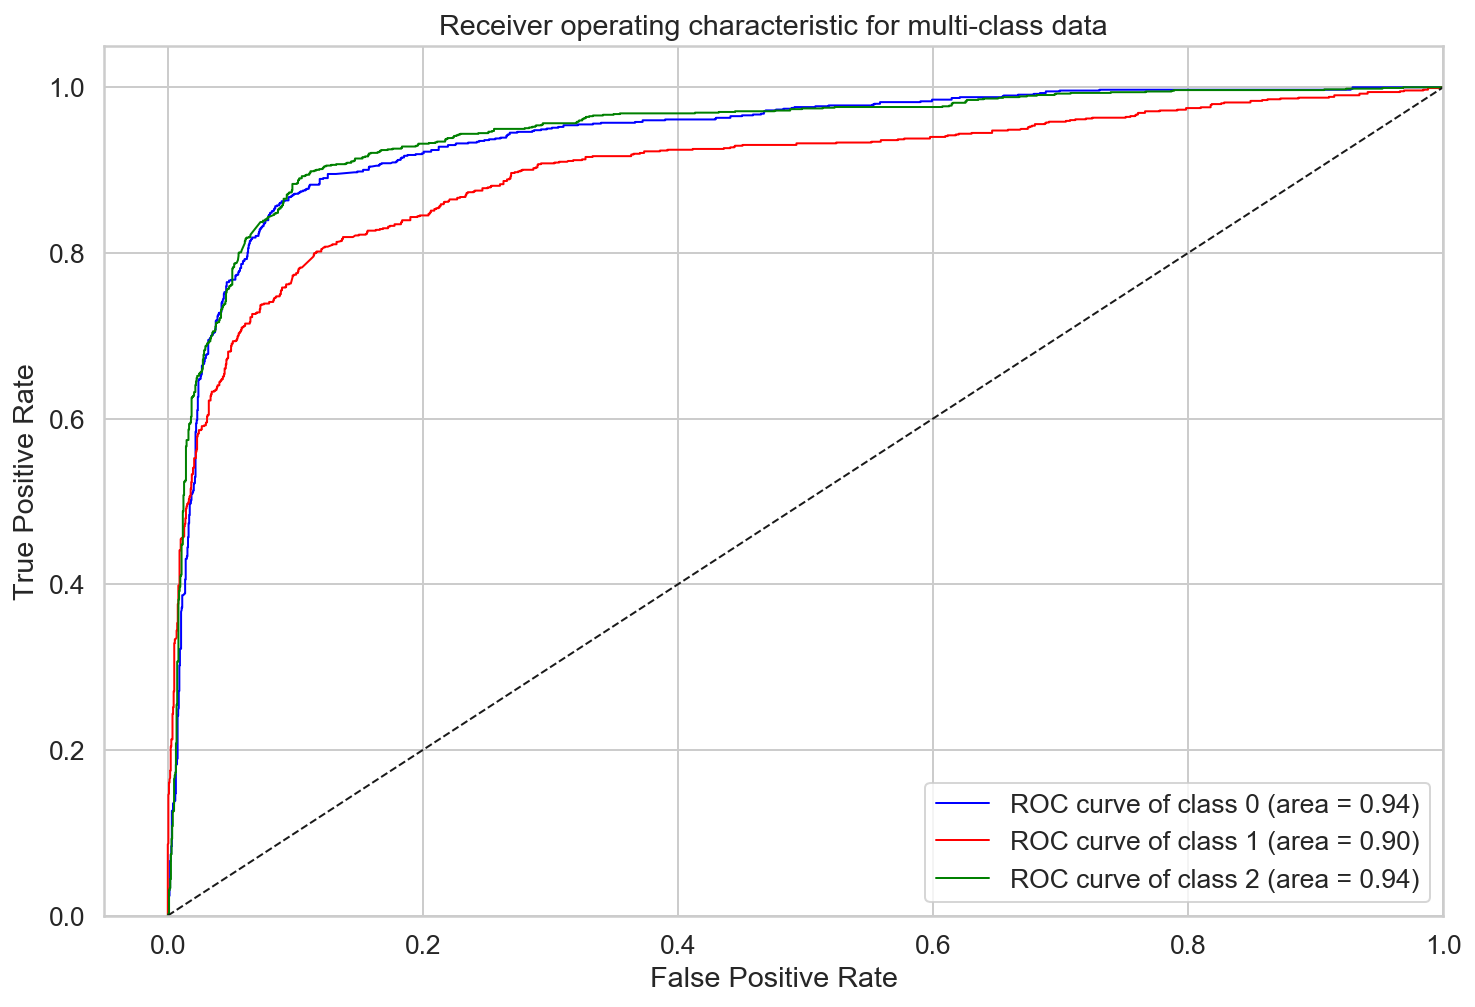

In [56]:
# actual_list = []
# pred = []
# pred_prob = []
from itertools import cycle
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3
lw = 1
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], np.array(pred_prob)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

In [28]:
cohen_kappa_score(actual_list, pred)
# 0.7375552735936348


0.7375552735936348